In [1]:
import wfdb
import numpy as np
import pandas as pd
import scipy.signal
import os
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

LABELS = ["H", "HA", "OA", "X", "CA", "CAA", "L", "LA", "A", "W", "1", "2", "3", "4", "R"]
DATA_DIR = "../data/"

def read_signals(record_name):
    record = wfdb.rdrecord(record_name)
    return record.p_signal, record.sig_name, record.fs

def extract_features(signal, fs):
    f, psd = scipy.signal.welch(signal, fs=fs)
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'power': np.sum(psd)
    }

def process_data(record_name, window_size=30):
    signals, signal_names, fs = read_signals(record_name)
    annotation = wfdb.rdann(record_name, 'st')
    segment_length = int(fs * window_size)

    data, labels = [], []

    for i in range(0, len(signals) - segment_length + 1, segment_length):
        segment_features = {}
        for j, signal_name in enumerate(signal_names):
            features = extract_features(signals[i:i+segment_length, j], fs)
            segment_features.update({f"{signal_name}_{k}": v for k, v in features.items()})

        segment_labels = {label: 0 for label in LABELS}
        for ann_time, ann_note in zip(annotation.sample, annotation.aux_note):
            if i <= ann_time < i + segment_length:
                for label in LABELS:
                    if label in ann_note:
                        segment_labels[label] = 1

        data.append(segment_features)
        labels.append(segment_labels)

    df = pd.DataFrame(data)
    df_labels = pd.DataFrame(labels)
    return pd.concat([df, df_labels], axis=1)

# Step 1: Load and process data
record_names = [
    "slp01a", "slp01b", "slp02a", "slp02b", "slp03", "slp04",
    "slp14", "slp16", "slp32", "slp37", "slp41", "slp45",
    "slp48", "slp59", "slp60", "slp61", "slp66", "slp67x"
]

dfs = []
print("\n🔍 Extracting features from records...")
for record in tqdm(record_names):
    rec_path = os.path.join(DATA_DIR, record)
    df = process_data(rec_path)
    df.to_csv(f"{record}_features.csv", index=False)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True).fillna(0)

# Step 2: Feature and label split
X = df_all.drop(columns=LABELS)
y = df_all[LABELS]

# Step 3: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Define individual models with GPU acceleration
rf = RandomForestClassifier(n_estimators=500, max_depth=40, random_state=42, n_jobs=-1)

mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128), activation='relu', solver='adam',
                    max_iter=600, early_stopping=True, random_state=42)  # CPU only

xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=10,
                    tree_method='gpu_hist', predictor='gpu_predictor',
                    use_label_encoder=False, eval_metric='logloss', verbosity=0)

lgb = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64,
                     device='gpu', gpu_platform_id=0, gpu_device_id=0, random_state=42)

# Step 6: Stacking classifier with these GPU-accelerated base models
base_learners = [
    ('rf', rf),     # CPU
    ('mlp', mlp),   # CPU
    ('xgb', xgb),   # GPU
    ('lgb', lgb)    # GPU
]

meta_learner = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)

# Step 7: MultiOutputClassifier wrapping StackingClassifier
stacking_ensemble = MultiOutputClassifier(
    StackingClassifier(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1),
    n_jobs=-1
)



🔍 Extracting features from records...


100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


In [3]:
stacking_ensemble.fit(X_train, y_train)

MultiOutputClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                RandomForestClassifier(max_depth=40,
                                                                                       n_estimators=500,
                                                                                       n_jobs=-1,
                                                                                       random_state=42)),
                                                               ('mlp',
                                                                MLPClassifier(early_stopping=True,
                                                                              hidden_layer_sizes=(512,
                                                                                                  256,
                                                                                                  128),
                                                                              max_iter=600,
                                                                              random_state=42)),
                                                               ('xgb',
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsamp...
                                                                              multi_strategy=None,
                                                                              n_estimators=300,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              predictor='gpu_predictor', ...)),
                                                               ('lgb',
                                                                LGBMClassifier(device='gpu',
                                                                               gpu_device_id=0,
                                                                               gpu_platform_id=0,
                                                                               learning_rate=0.05,
                                                                               n_estimators=300,
                                                                               num_leaves=64,
                                                                               random_state=42))],
                                                   final_estimator=RandomForestClassifier(max_depth=10,
                                                                                          n_estimators=200,
                                                                                          n_jobs=-1,
                                                                                          random_state=42),
                                                   n_jobs=-1),
                      n_jobs=-1)

In [4]:
# Step 8: Evaluate
y_pred = stacking_ensemble.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=LABELS))


📊 Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.33      0.43       203
          HA       0.64      0.30      0.41       150
          OA       0.84      0.68      0.76       133
           X       0.69      0.62      0.65       304
          CA       0.39      0.23      0.29        47
         CAA       0.42      0.26      0.32        38
           L       0.72      0.54      0.62        97
          LA       0.62      0.43      0.51        37
           A       0.72      0.48      0.58       368
           W       0.82      0.84      0.83       622
           1       0.67      0.48      0.56       340
           2       0.81      0.78      0.80       783
           3       0.71      0.53      0.61       109
           4       0.79      0.61      0.69        38
           R       0.86      0.72      0.78       151

   micro avg       0.76      0.63      0.69      3420
   macro avg       0.69      0.52      0.59      3420

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\prana\anaconda3\envs\tds\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\prana\anaconda3\envs\tds\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\prana\anaconda3\envs\tds\lib\subprocess.py", line 951, in __init__
    self._execute_

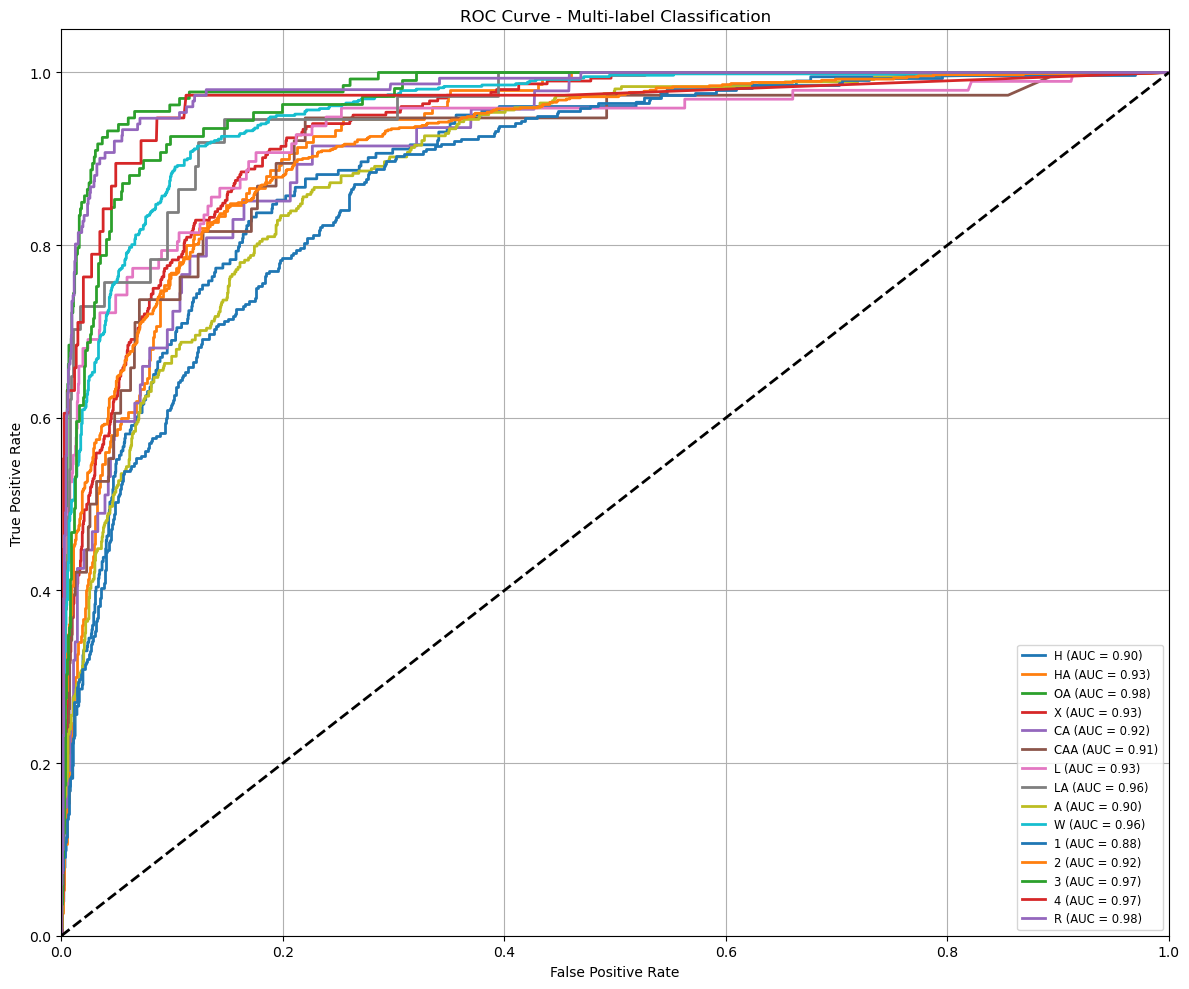

In [6]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# Ensure predicted probabilities are available
y_score = stacking_ensemble.predict_proba(X_test)

# Reshape predict_proba output: list of arrays -> 2D array [n_samples, n_labels]
y_score_matrix = np.array([probs[:, 1] for probs in y_score]).T  # Keep positive class probs

# Binarize labels (though already 0/1, ensures correct format)
y_test_bin = y_test.to_numpy()

# Plot ROC for each class
plt.figure(figsize=(12, 10))
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-label Classification')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

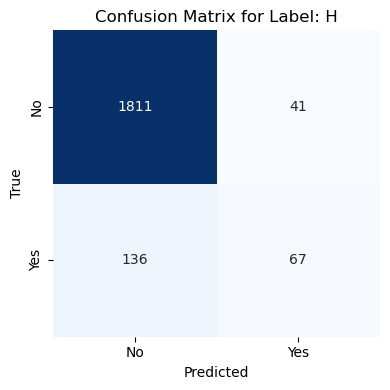

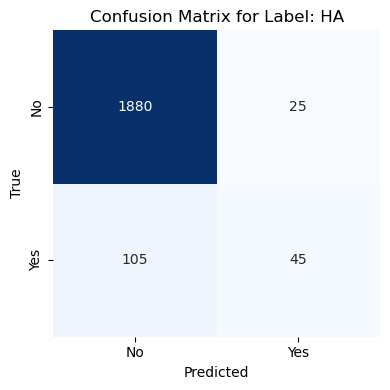

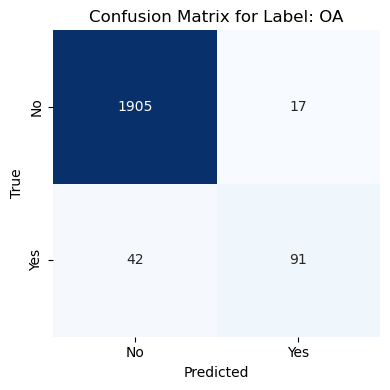

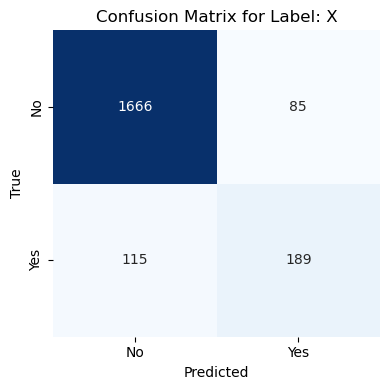

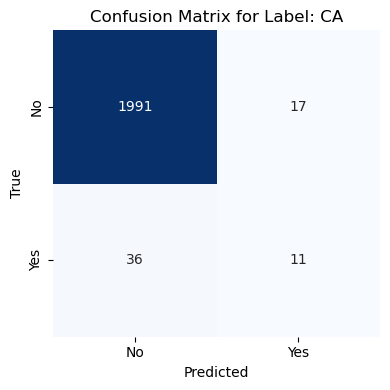

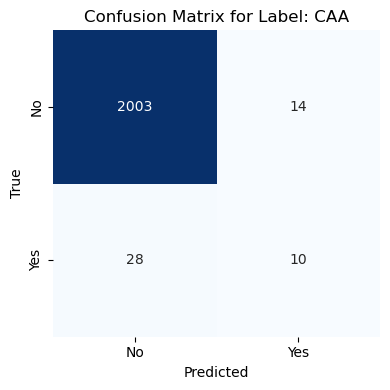

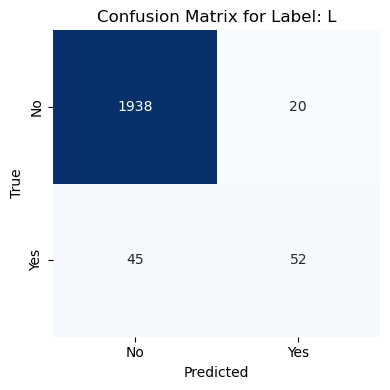

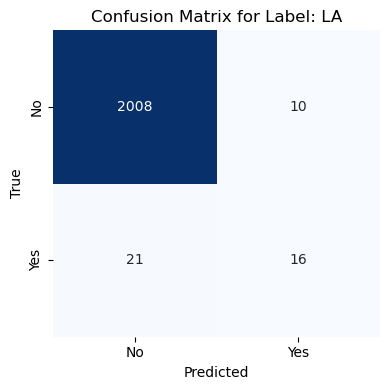

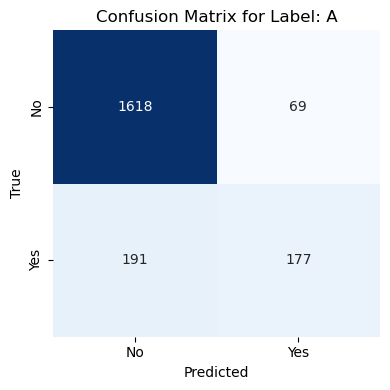

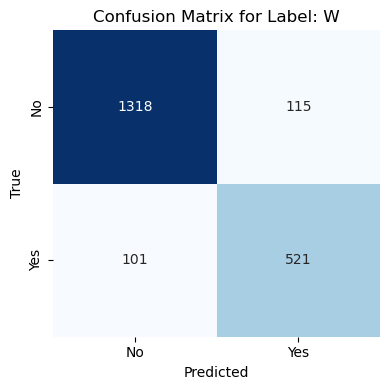

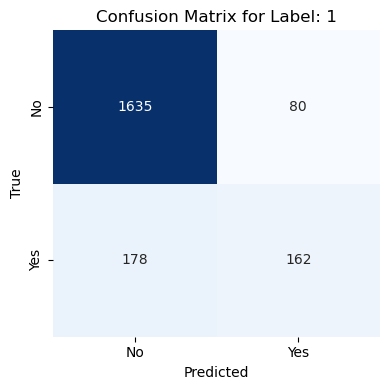

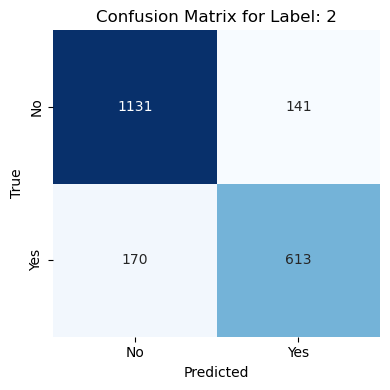

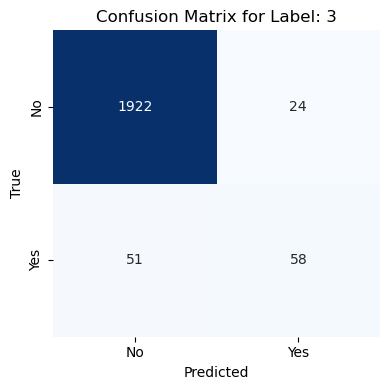

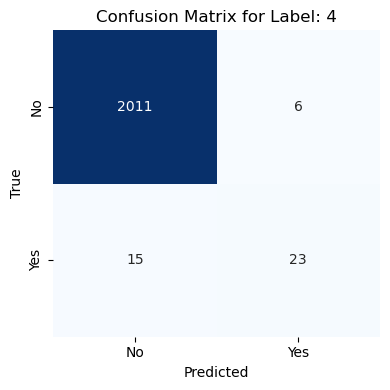

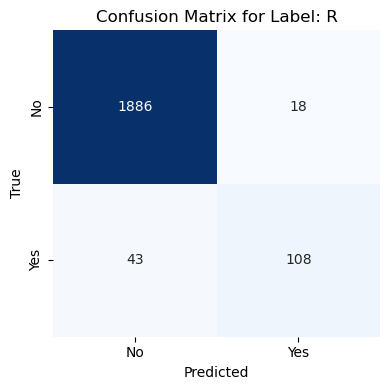

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions to DataFrame for easier handling
y_pred_df = pd.DataFrame(y_pred, columns=LABELS) if isinstance(y_pred, np.ndarray) else pd.DataFrame(y_pred, columns=LABELS)

# Plot confusion matrix for each label
for label in LABELS:
    cm = confusion_matrix(y_test[label], y_pred_df[label])
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for Label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Convert y_pred to DataFrame if needed
y_pred_df = pd.DataFrame(y_pred, columns=LABELS) if isinstance(y_pred, np.ndarray) else pd.DataFrame(y_pred, columns=LABELS)

print("🔎 Accuracy & AUC for Each Label:\n")
label_accuracies = {}
label_aucs = {}
s = 0
i = 0
for label in LABELS:
    i += 1
    acc = accuracy_score(y_test[label], y_pred_df[label])
    s += acc
    try:
        auc = roc_auc_score(y_test[label], y_pred_df[label])
    except ValueError:
        auc = float('nan')  # If AUC cannot be computed (e.g. only one class present)

    label_accuracies[label] = acc
    label_aucs[label] = auc

    print(f"{label:>3} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

# Macro and micro averages (optional)
try:
    macro_auc = roc_auc_score(y_test, y_pred_df, average='macro')
    micro_auc = roc_auc_score(y_test, y_pred_df, average='micro')
    print(f"\n🌐 Macro AUC: {macro_auc:.4f}")
    print(f"🌍 Micro AUC: {micro_auc:.4f}")
except ValueError:
    print("\n⚠️ AUC could not be computed for all labels due to class imbalance.")

print(s/i)


🔎 Accuracy & AUC for Each Label:

  H | Accuracy: 0.9139 | AUC: 0.6540
 HA | Accuracy: 0.9367 | AUC: 0.6434
 OA | Accuracy: 0.9713 | AUC: 0.8377
  X | Accuracy: 0.9027 | AUC: 0.7866
 CA | Accuracy: 0.9742 | AUC: 0.6128
CAA | Accuracy: 0.9796 | AUC: 0.6281
  L | Accuracy: 0.9684 | AUC: 0.7629
 LA | Accuracy: 0.9849 | AUC: 0.7137
  A | Accuracy: 0.8735 | AUC: 0.7200
  W | Accuracy: 0.8949 | AUC: 0.8787
  1 | Accuracy: 0.8745 | AUC: 0.7149
  2 | Accuracy: 0.8487 | AUC: 0.8360
  3 | Accuracy: 0.9635 | AUC: 0.7599
  4 | Accuracy: 0.9898 | AUC: 0.8011
  R | Accuracy: 0.9703 | AUC: 0.8529

🌐 Macro AUC: 0.7469
🌍 Micro AUC: 0.8009
0.9364476885644769
